In [37]:
import pandas as pd
import re
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from Levenshtein import distance as edit_distance
from itertools import combinations

In [41]:
df = pd.read_csv('registration-trimmed.csv', encoding = "ISO-8859-1")    
df.head()

,country,school,postal_code
0,Malaysia,POWIIS,.
1,Philippines,"Bangladesh International School, English section",21452
2,Saudi Arabia,Global International School,23213
3,Malaysia,Kolej Tuanku Ja'afar,71700
4,China,the middle school attach to Guangxi university,530000


In [42]:
df.shape

(175, 3)

# Handle Missing Data

In [43]:
# Missing Data
df.isna().mean()

country        0.005714
school         0.011429
postal_code    0.011429
dtype: float64

In [44]:
df[df['school'].isna()]

,country,school,postal_code
56,NaN,NaN,NaN
169,Malaysia,NaN,NaN


In [45]:
df = df[~df['school'].isna()]
df.isna().mean()

country        0.0
school         0.0
postal_code    0.0
dtype: float64

# Convert to string values, standardize format

In [46]:
for col in df.columns:
    df[col] = df[col].astype(str).str.strip()
    df[col] = df[col].str.lower()
    df[col] = df[col].apply(lambda text: re.sub('\s+', ' ', text))
df.head()

,country,school,postal_code
0,malaysia,powiis,.
1,philippines,"bangladesh international school, english section",21452
2,saudi arabia,global international school,23213
3,malaysia,kolej tuanku ja'afar,71700
4,china,the middle school attach to guangxi university,530000


In [47]:
df.shape

(173, 3)

# Inspect Country

In [48]:
df['country'].value_counts().sort_index()

brunei darussalam         2
china                     2
egypt                     1
hong kong (s.a.r.)        1
indonesia                 1
iraq                      1
japan                     2
kuwait                    1
malaysia                148
maldives                  2
oman                      1
philippines               1
qatar                     1
saudi arabia              1
singapore                 6
sudan                     1
united arab emirates      1
Name: country, dtype: int64

# Inspect Postal Code

In [49]:
df['postal_code'].str.len().value_counts().sort_index()

1      12
3       1
4       2
5     140
6       9
8       2
9       1
10      1
11      1
12      2
17      1
45      1
Name: postal_code, dtype: int64

In [50]:
df[df['postal_code'].str.len() != 5]

,country,school,postal_code
0,malaysia,powiis,.
4,china,the middle school attach to guangxi university,530000
6,qatar,the international school of choueifat,0
9,oman,the sultan's school,don't know
10,singapore,global indian international school,459663
12,china,ningbo binhai internationalcooperation school,315800
20,malaysia,taylor's international school kuala lumpur,-
21,singapore,nan chiau high school,545079
22,singapore,nan chiau high school,545079
23,singapore,nan chiau high school,545079


In [51]:
#The only acceptable format are 
# empty
# 5 digits 
# 6 digits
# 3 digits follows by hypen and 4 digits
def is_valid_postal_code(t):
    return re.match('^\d{5}$', t) is not None or \
           re.match('^\d{6}$', t) is not None or \
           re.match('^\d{3}-\d{4}$', t) is not None or \
           t == ''

df[~df['postal_code'].apply(is_valid_postal_code)]

,country,school,postal_code
0,malaysia,powiis,.
6,qatar,the international school of choueifat,0
9,oman,the sultan's school,don't know
20,malaysia,taylor's international school kuala lumpur,-
30,iraq,almtamezen-harthea,non
33,malaysia,taylor's international school kuala lumpur,i don't know
45,malaysia,taylor's college,.
51,brunei darussalam,chung hua middle school,ka1131
58,malaysia,kuen cheng high school,-
61,malaysia,seri omega,-


In [52]:
# Fix invalid postal code, convert to missing values
df['postal_code'].loc[~df['postal_code'].apply(is_valid_postal_code)] = ''
df['postal_code'].apply(is_valid_postal_code).mean()

1.0

In [53]:
# Check again
df['postal_code'].str.len().value_counts().sort_index()

0     23
5    140
6      8
8      2
Name: postal_code, dtype: int64

# Identify school groups

In [54]:
df['school'].value_counts()

smjk yu hua                              7
smk gajah berang                         4
catholic high school                     4
nan chiau high school                    3
smjk jit sin                             3
                                        ..
smk taman setiawangsa                    1
smk tun habab                            1
seri omega                               1
chong hwa independent high school        1
center for higher secondary education    1
Name: school, Length: 129, dtype: int64

In [55]:
school_grps = df.groupby(['country', 'postal_code']) \
                  .apply(lambda x: set(x['school'])).reset_index() \
                  .rename(columns={0:'schools'})
school_grps['n_schools'] = school_grps['schools'].apply(len)
school_grps = school_grps[school_grps['n_schools'] > 1]
school_grps

,country,postal_code,schools,n_schools
0,brunei darussalam,,"{chung hua middle school, chung hua middle sch...",2
10,malaysia,,"{smk tengku mahmud 2, sri emas international s...",16
12,malaysia,11600,"{penang free school, han chiang high school}",2
16,malaysia,14000,"{jit sin, smjk jit sin, high school bukit mert...",3
18,malaysia,26600,"{sekolah sains sultan haji ahmad shah, pekan, ...",2
25,malaysia,41200,"{smjk chung hwa, smk bukit tinggi, smk tengku ...",4
26,malaysia,43000,"{smjk yu hua kajang, smk bandar baru sungai lo...",4
29,malaysia,46000,"{catholic high school, smjk katholik pj}",2
31,malaysia,47100,"{help international school, smk bandar puchong...",5
35,malaysia,47400,"{smk damansara utama, smk damansara jaya}",2


# Create School Mapper 

In [56]:
#################
# Configuration
################
EDIT_DISTANCE_FACTOR = 1/3
MAX_WORD_DIFFERENCES = 3

def get_school_mapper(df, country, postal_code):
    schools_same_area = set(df.query("country==@country and postal_code==@postal_code")['school'])

    G = nx.Graph()

    for s1, s2 in combinations(schools_same_area, 2):
        ######################
        # partial matching
        ######################
        if s1 in s2 or s2 in s1:
            G.add_edge(s1, s2)

        ##############################
        # Check character differences
        ##############################
        s1_num_words = len(s1.split(' '))
        s2_num_words = len(s2.split(' '))
        diff_in_words = abs(s1_num_words - s2_num_words)
        if edit_distance(s1, s2) <= (min(len(s1), len(s2)) * EDIT_DISTANCE_FACTOR) and \
           diff_in_words <= MAX_WORD_DIFFERENCES:
            G.add_edge(s1, s2)

    ###########################
    # Create homogenous groups
    ###########################
    similar_schools = list(nx.connected_components(G))

    ################
    # Create lookup
    ################
    school_mapper = {}
    for schools in similar_schools:
        ######################################
        # Set main school as the shortest one
        ######################################
        main_school = min(schools, key=lambda x: len(x))
        for school in schools:
            school_mapper[school] = main_school

    return school_mapper

In [57]:
get_school_mapper(df, 'malaysia', '47500')

{'sri kuala lumpur': 'sri kuala lumpur',
 'sri kuala lumpur international school': 'sri kuala lumpur',
 'sri kuala lumpur secondary school': 'sri kuala lumpur'}

In [58]:
get_school_mapper(df, 'malaysia', '56100')

{'smk seri bintang selatan': 'smk seri bintang utara',
 'smk seri bintang seletan': 'smk seri bintang utara',
 'smk seri bintang utara': 'smk seri bintang utara',
 'sri sempurna': 'sri sempurna',
 'sri sempurna international school': 'sri sempurna'}

# Inspect all mappers (Modify manually if necessary)

In [59]:
school_grps = df.groupby(['country', 'postal_code']) \
                  .apply(lambda x: set(x['school'])).reset_index() \
                  .rename(columns={0:'schools'})
school_grps['n_schools'] = school_grps['schools'].apply(len)
school_grps = school_grps[school_grps['n_schools'] > 1]

school_mappers = {}
for row in school_grps[['country', 'postal_code']].itertuples(index=False):
    country, postal_code = row[0], row[1]
    mapper = get_school_mapper(df, country, postal_code)
    if len(mapper) > 0:
        school_mappers[(country, postal_code)] = mapper
    
school_mappers

{('brunei darussalam',
  ''): {'chung hua middle school': 'chung hua middle school', 'chung hua middle school, kuala belait': 'chung hua middle school'},
 ('malaysia', '14000'): {'jit sin': 'jit sin', 'smjk jit sin': 'jit sin'},
 ('malaysia',
  '26600'): {'sekolah sains sultan haji ahmad shah': 'sekolah sains sultan haji ahmad shah', 'sekolah sains sultan haji ahmad shah, pekan': 'sekolah sains sultan haji ahmad shah'},
 ('malaysia', '43000'): {'smjk yu hua': 'smjk yu hua',
  'smjk yu hua kajang': 'smjk yu hua'},
 ('malaysia',
  '47100'): {'axcel international school': 'help international school', 'help international school': 'help international school'},
 ('malaysia', '47400'): {'smk damansara jaya': 'smk damansara jaya',
  'smk damansara utama': 'smk damansara jaya'},
 ('malaysia', '47500'): {'sri kuala lumpur': 'sri kuala lumpur',
  'sri kuala lumpur international school': 'sri kuala lumpur',
  'sri kuala lumpur secondary school': 'sri kuala lumpur'},
 ('malaysia', '52100'): {'smk k

In [60]:
# modify if necessary:
school_mappers = {('brunei darussalam',
  ''): {'chung hua middle school, kuala belait': 'chung hua middle school'},
 ('malaysia', '14000'): {'smjk jit sin': 'jit sin'},
 ('malaysia',
  '26600'): {'sekolah sains sultan haji ahmad shah, pekan': 'sekolah sains sultan haji ahmad shah'},
 ('malaysia', '43000'): {'smjk yu hua kajang': 'smjk yu hua'},
 ('malaysia',
  '47100'): {'axcel international school': 'help international school'},
 ('malaysia', '47400'): {'smk damansara utama': 'smk damansara jaya'},
 ('malaysia',
  '47500'): {'sri kuala lumpur international school': 'sri kuala lumpur',
  'sri kuala lumpur secondary school': 'sri kuala lumpur'},
 ('malaysia', '52100'): {'smk kepong baru': 'smk kepong'},
 ('malaysia', '56100'): {'smk seri bintang selatan': 'smk seri bintang utara',
  'smk seri bintang seletan': 'smk seri bintang utara',
  'sri sempurna international school': 'sri sempurna'},
 ('maldives',
  '20159'): {'centre for higher secondary education (chse)': 'center for higher secondary education'}}

# Fix school names

In [61]:
df_clean = df.copy()

def change_school(row, mapper):
    school = row['school']
    index = row.name
    if school in mapper and school != mapper[school]:
        print(f'Changed row {index}-th school: "{school}" -> "{mapper[school]}"')
        return mapper[school]
    else:
        return school

for (country, postal_code), school_mapper in school_mappers.items():
    df_qry = df_clean.query("country==@country and postal_code==@postal_code")
    new_schools = df_qry.apply(lambda row: change_school(row, school_mapper), axis=1)
    df_clean['school'].loc[df_qry.index] = new_schools

Changed row 78-th school: "chung hua middle school, kuala belait" -> "chung hua middle school"
Changed row 13-th school: "smjk jit sin" -> "jit sin"
Changed row 141-th school: "smjk jit sin" -> "jit sin"
Changed row 171-th school: "sekolah sains sultan haji ahmad shah, pekan" -> "sekolah sains sultan haji ahmad shah"
Changed row 113-th school: "smjk yu hua kajang" -> "smjk yu hua"
Changed row 41-th school: "axcel international school" -> "help international school"
Changed row 120-th school: "smk damansara utama" -> "smk damansara jaya"
Changed row 42-th school: "sri kuala lumpur international school" -> "sri kuala lumpur"
Changed row 67-th school: "sri kuala lumpur secondary school" -> "sri kuala lumpur"
Changed row 129-th school: "smk kepong baru" -> "smk kepong"
Changed row 57-th school: "smk seri bintang selatan" -> "smk seri bintang utara"
Changed row 62-th school: "sri sempurna international school" -> "sri sempurna"
Changed row 84-th school: "sri sempurna international school" -

In [62]:
df_clean['school'].value_counts()

smjk yu hua                          8
smk seri bintang utara               4
sri kuala lumpur                     4
catholic high school                 4
smk gajah berang                     4
                                    ..
smk tun habab                        1
smk bukit mewah                      1
chong hwa independent high school    1
smjk jit sin                         1
wesley methodist ipoh                1
Name: school, Length: 117, dtype: int64

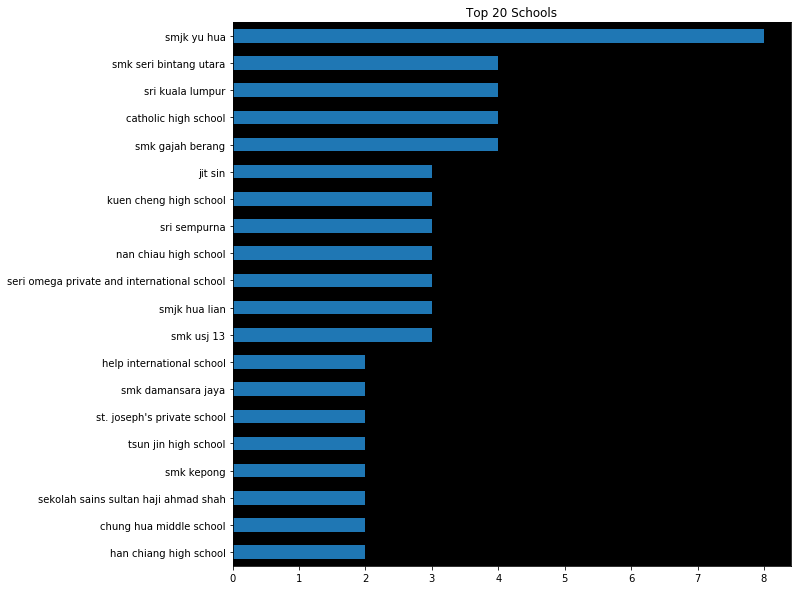

In [63]:
top = 20
fig, ax = plt.subplots(figsize=(10, 10))
top_schools = df_clean['school'].value_counts()[:top].plot.barh(ax=ax)
ax.invert_yaxis()
ax.set_facecolor('black')
ax.set_title(f'Top {top} Schools')
plt.show()